<a href="https://colab.research.google.com/github/SaiVaichal/-Atari_Breakout_playing_agent_Reinforcement_Learning/blob/main/Copy_of_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym[atari,accept-rom-license] tensorflow matplotlib seaborn pandas opencv-python

INFO: pip is looking at multiple versions of gym[accept-rom-license,atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 23.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 34.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.9 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827730 sha256=d15a17e2aa56942990c75b69ebbf828de9dcd3cfabb3072dfe4002fd6cb5e28d
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_

In [ ]:
import os
import gym
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import deque

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Lambda
from tensorflow.keras.optimizers import Adam
import time
from IPython.display import clear_output, display
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

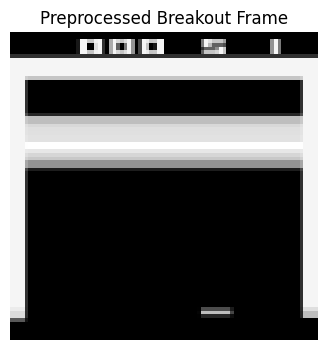

State shape: (84, 84)
Number of possible actions: 4


In [ ]:
# Create a class to handle the Atari Breakout environment
class AtariBreakoutEnv:
    def __init__(self):
    # Create the Atari Breakout environment - disable the environment checker
       self.env = gym.make('ALE/Breakout-v5', render_mode=None, disable_env_checker=True)
       self.action_size = self.env.action_space.n

    def reset(self):
        # Reset the environment and preprocess the initial state
        return self.preprocess_frame(self.env.reset()[0])

    def step(self, action):
        # Take a step in the environment and preprocess the next state
        next_state, reward, done, truncated, info = self.env.step(action)
        return self.preprocess_frame(next_state), reward, done or truncated, info

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()

    def preprocess_frame(self, frame):
        """Preprocess frames for input to the neural network"""
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Resize to 84x84
        resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)

        # Normalize pixel values
        normalized = resized / 255.0

        return normalized

# Let's test the environment
env = AtariBreakoutEnv()
state = env.reset()

# Display the preprocessed frame
plt.figure(figsize=(4, 4))
plt.imshow(state, cmap='gray')
plt.title('Preprocessed Breakout Frame')
plt.axis('off')
plt.show()

print(f"State shape: {state.shape}")
print(f"Number of possible actions: {env.action_size}")

env.close()


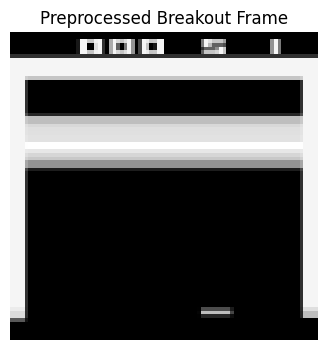

State shape: (84, 84)
Number of possible actions: 4


In [ ]:
# Create a class to handle the Atari Breakout environment
class AtariBreakoutEnv:
    def __init__(self):
    # Create the Atari Breakout environment - disable the environment checker
       self.env = gym.make('ALE/Breakout-v5', render_mode=None, disable_env_checker=True)
       self.action_size = self.env.action_space.n

    def reset(self):
        # Reset the environment and preprocess the initial state
        return self.preprocess_frame(self.env.reset()[0])

    def step(self, action):
        # Take a step in the environment and preprocess the next state
        next_state, reward, done, truncated, info = self.env.step(action)
        return self.preprocess_frame(next_state), reward, done or truncated, info

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()

    def preprocess_frame(self, frame):
        """Preprocess frames for input to the neural network"""
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Resize to 84x84
        resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)

        # Normalize pixel values
        normalized = resized / 255.0

        return normalized

# Let's test the environment
env = AtariBreakoutEnv()
state = env.reset()

# Display the preprocessed frame
plt.figure(figsize=(4, 4))
plt.imshow(state, cmap='gray')
plt.title('Preprocessed Breakout Frame')
plt.axis('off')
plt.show()

print(f"State shape: {state.shape}")
print(f"Number of possible actions: {env.action_size}")

env.close()


In [ ]:
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    @property
    def size(self):
        """Return the size of the memory."""
        return len(self.memory)


In [ ]:
class DQNAgent:
    def __init__(self, state_shape, action_size, learning_rate=0.0001, gamma=0.99,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 memory_size=10000, batch_size=32):

        self.state_shape = state_shape
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        self.memory = ReplayBuffer(memory_size)
        self.model = self._build_dqn()
        self.target_model = self._build_dqn()
        self.update_target_model()

        self.loss_fn = tf.keras.losses.MeanSquaredError()
        self.optimizer = Adam(learning_rate=self.learning_rate)

        self.loss_history = []
        self.reward_history = []
        self.q_values_history = []

    def _build_dqn(self):
        model = Sequential([
            Input(shape=self.state_shape),
            Lambda(lambda x: tf.expand_dims(x, axis=-1)),  # Add channel dim
            Conv2D(32, (8, 8), strides=(4, 4), activation='relu'),
            Conv2D(64, (4, 4), strides=(2, 2), activation='relu'),
            Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

    def act(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        if len(state.shape) == 2:
            state = np.expand_dims(state, axis=0)
        if len(state.shape) == 3:
            state = np.expand_dims(state, axis=-1)
        q_values = self.model.predict(state, verbose=0)
        self.q_values_history.append(np.mean(q_values))
        return np.argmax(q_values[0])

    def replay(self):
        if self.memory.size < self.batch_size:
            return 0
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        if len(states.shape) == 3:
            states = np.expand_dims(states, axis=-1)
            next_states = np.expand_dims(next_states, axis=-1)

        targets = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            targets[i, actions[i]] = rewards[i] if dones[i] else rewards[i] + self.gamma * np.max(next_q_values[i])

        loss = self.model.train_on_batch(states, targets)
        self.loss_history.append(loss)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# Example usage
agent = DQNAgent(state_shape=(84, 84), action_size=4)
agent.model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 84, 84, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 20, 20, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,680,036 (6.41 MB)

 Trainable params: 1,680,036 (6.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
env = AtariBreakoutEnv()
agent = DQNAgent(state_shape=(84, 84), action_size=env.action_size)


In [ ]:
episodes = 70
max_steps = 2000  # per episode, you can reduce further to speed it up
target_update_freq = 5  # update target more frequently for quicker learning

In [ ]:
for episode in range(episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)

        loss = agent.replay()
        state = next_state
        total_reward += reward

        if done:
            break

    agent.reward_history.append(total_reward)

    if episode % target_update_freq == 0:
        agent.update_target_model()

    print(f"Episode {episode + 1}, Reward: {total_reward}, Epsilon: {agent.epsilon:.4f}, Loss: {loss:.4f}")
    print(agent.reward_history)



Episode 1, Reward: 1.0, Epsilon: 0.4834, Loss: 0.0002
[1.0]
Episode 2, Reward: 3.0, Epsilon: 0.1064, Loss: 0.0015
[1.0, 3.0]
Episode 3, Reward: 2.0, Epsilon: 0.0168, Loss: 0.0016
[1.0, 3.0, 2.0]
Episode 4, Reward: 0.0, Epsilon: 0.0100, Loss: 0.0014
[1.0, 3.0, 2.0, 0.0]
Episode 5, Reward: 2.0, Epsilon: 0.0100, Loss: 0.0013
[1.0, 3.0, 2.0, 0.0, 2.0]
Episode 6, Reward: 0.0, Epsilon: 0.0100, Loss: 0.0012
[1.0, 3.0, 2.0, 0.0, 2.0, 0.0]
Episode 7, Reward: 0.0, Epsilon: 0.0100, Loss: 0.0012
[1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0]
Episode 8, Reward: 0.0, Epsilon: 0.0100, Loss: 0.0012
[1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0]
Episode 9, Reward: 1.0, Epsilon: 0.0100, Loss: 0.0012
[1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0]
Episode 10, Reward: 0.0, Epsilon: 0.0100, Loss: 0.0012
[1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Episode 11, Reward: 4.0, Epsilon: 0.0100, Loss: 0.0012
[1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 4.0]
Episode 12, Reward: 1.0, Epsilon: 0.0100, Loss: 0.0012
[1.0, 3.

In [ ]:

agent.save("dqn_breakout.weights.h5")


In [ ]:
print(agent.reward_history)


[1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 4.0, 1.0, 1.0, 0.0, 7.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 7.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 1.0, 2.0, 2.0, 4.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 1.0, 1.0, 1.0, 3.0, 1.0, 0.0, 0.0, 4.0, 2.0, 0.0, 3.0, 1.0, 0.0, 1.0, 0.0, 2.0, 5.0, 1.0, 2.0, 2.0]


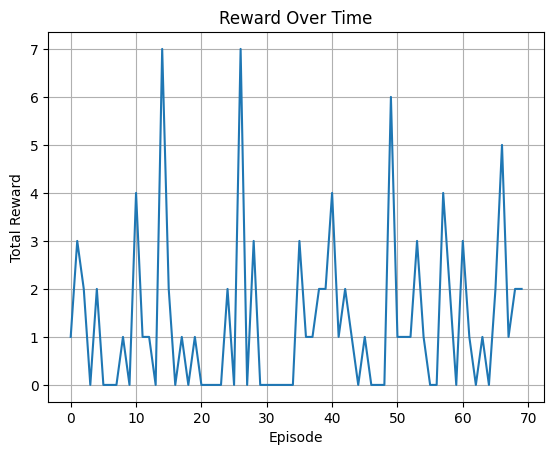

In [ ]:
import matplotlib.pyplot as plt

plt.plot(agent.reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Over Time")
plt.grid()
plt.show()


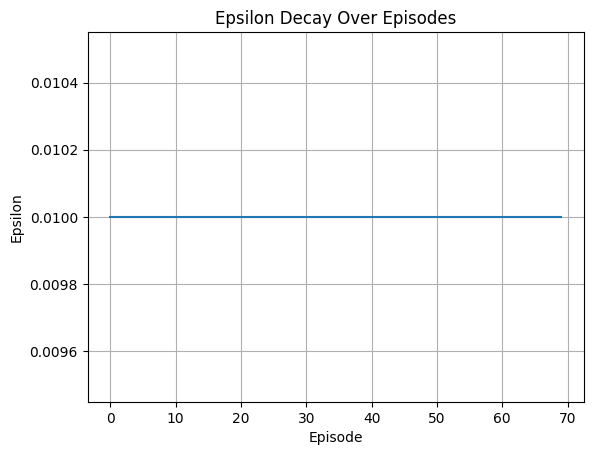

In [ ]:
epsilons = [max(agent.epsilon_min, agent.epsilon * (agent.epsilon_decay ** i)) for i in range(len(agent.reward_history))]

plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay Over Episodes")
plt.grid()
plt.show()


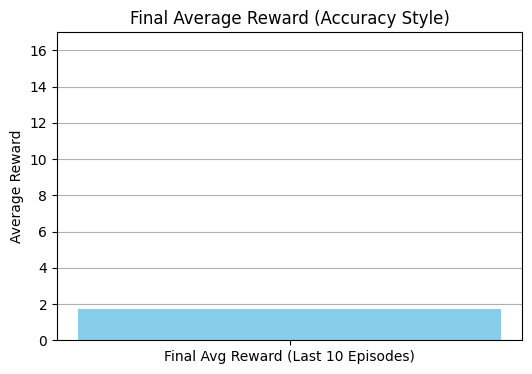

In [ ]:
# Calculate average reward over last N episodes
N = 10
final_avg_reward = np.mean(agent.reward_history[-N:])

plt.figure(figsize=(6, 4))
plt.bar(["Final Avg Reward (Last 10 Episodes)"], [final_avg_reward], color='skyblue')
plt.ylim(0, max(agent.reward_history) + 10)
plt.title("Final Average Reward (Accuracy Style)")
plt.ylabel("Average Reward")
plt.grid(axis='y')
plt.show()


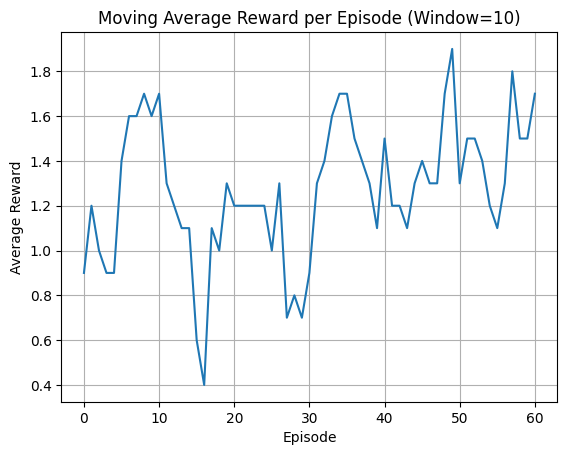

In [ ]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = moving_average(agent.reward_history, window_size=10)

plt.plot(smoothed_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Moving Average Reward per Episode (Window=10)")
plt.grid()
plt.show()


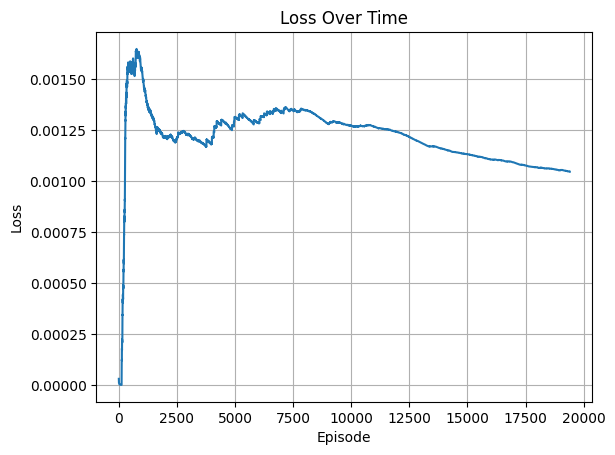

In [ ]:
plt.plot(agent.loss_history)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.grid()
plt.show()



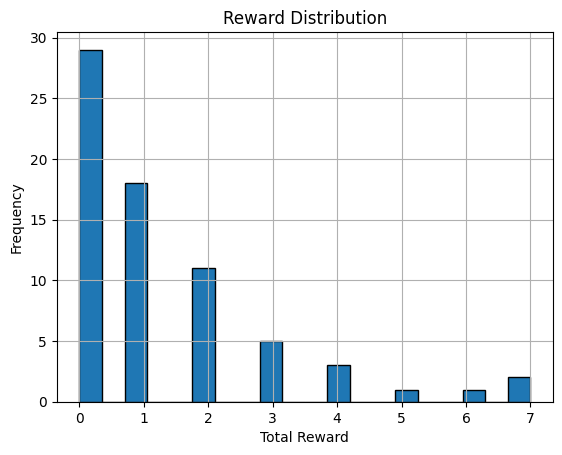

In [ ]:
plt.hist(agent.reward_history, bins=20, edgecolor='black')
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution")
plt.grid()
plt.show()
